In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pickle

import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
import os
import copy

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 5
image_size = 72
num_heads = 4
projection_dim = 64
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [2048, 1048] 

num_classes = 10
input_shape=(32,32,3)

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = "VALID", 
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )
    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
        

In [14]:
def create_vit_classifier(input_patch_size, input_data_augmentation):
    inputs = layers.Input(shape=input_shape)
    #augmented data
    augmented = input_data_augmentation(inputs)
    #create patches
    patches = Patches(input_patch_size)(augmented)
    # encode patches
    num_patches = (image_size // input_patch_size) ** 2
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer Block
    for _ in range(transformer_layers):
        # layer normalisation
        x1 = layers.LayerNormalization(epsilon= 1e-6)(encoded_patches)
        # Create a multi -  head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads,
            key_dim = projection_dim,
            dropout = 0
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        #layer normalisation
        x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
        # MLP
        x2 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0)
        # skip connection2
        encoded_patches =  layers.Add()([x3, x2])
    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0)(representation)

    # Add MLP 
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0)
    #classify ouputs
    logits = layers.Dense(num_classes)(features)
    # Create the Keras Model
    model = keras.Model(inputs = inputs, outputs = logits)
    return model

In [15]:
def build_ViT_model(input_patch_size, input_data_augmentation):
    
    model = create_vit_classifier(input_patch_size, input_data_augmentation)
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ]
    )

    return model

In [16]:
# Run Noise_process before run this file

def get_dataset(obj_name):
    filename_labels = 'train_labels.npy'
    filename_origin = 'origin_cifar10.npy'
    filename_small_noise = 'small_noise_cifar10.npy'
    filename_medium_noise = 'medium_noise_cifar10.npy'
    filename_large_noise = 'large_noise_cifar10.npy'
    
    train_set = None
    s_size = 6000

    if obj_name == 'origin':
        train_set = np.load(filename_origin)[:s_size]
    elif obj_name == 'small_noise':
        train_set = np.load(filename_small_noise)[:s_size]
    elif obj_name == 'medium_noise':
        train_set = np.load(filename_medium_noise)[:s_size]
    elif obj_name == 'large_noise':
        train_set = np.load(filename_large_noise)[:s_size]
    else:
        raise ValueError(f"Unknown obj_name: {obj_name}")

    label_set = np.load(filename_labels)[:s_size] if train_set.size > 0 else None

    if label_set is None or train_set is None:
        print("Run Noise_process.ipynb before run this file")
    
    return train_set, label_set

In [17]:
def get_processed_dataset(model_name):
    train_set, label_set = get_dataset(model_name)

    return train_set, label_set

In [18]:
ORIGIN='origin'
SMALL='small_noise'
MEDIUM='medium_noise'
LARGE='large_noise'
all_dataset = [ORIGIN, SMALL, MEDIUM, LARGE]

# ViT: learning_rate, patch_size
best_config_origin_ViT = {'name': ORIGIN, 'patch_size': 12}
best_config_small_ViT = {'name': SMALL, 'patch_size': 12}
best_config_medium_ViT = {'name': MEDIUM, 'patch_size': 12}
best_config_large_ViT = {'name': LARGE, 'patch_size': 12}

best_config_ViT = []
best_config_ViT.append(best_config_origin_ViT)
best_config_ViT.append(best_config_small_ViT)
best_config_ViT.append(best_config_medium_ViT)
best_config_ViT.append(best_config_large_ViT)

In [19]:
def plot_learning_curves(all_history, model_name):
    train_loss = np.mean([h['loss'] for h in all_history], axis=0)
    val_loss = np.mean([h['val_loss'] for h in all_history], axis=0)
    train_accuracy = np.mean([h['accuracy'] for h in all_history], axis=0)
    val_accuracy = np.mean([h['val_accuracy'] for h in all_history], axis=0)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss Curve {model_name} ViT')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'Accuracy Curve {model_name} ViT')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

Fold 1/20
38/38 [==============================] - 2s 42ms/step
Run origin, in small_noise at Fold 1/20: Accuracy: 0.45166666666666666, Precision: 0.4605623826103512, Recall: 0.45313301731441
38/38 [==============================] - 2s 42ms/step
Run origin, in medium_noise at Fold 1/20: Accuracy: 0.42833333333333334, Precision: 0.4340189535625921, Recall: 0.42921897849782764
38/38 [==============================] - 2s 46ms/step
Run origin, in large_noise at Fold 1/20: Accuracy: 0.3175, Precision: 0.3778607118921429, Recall: 0.31707361648505483
Fold 2/20
38/38 [==============================] - 2s 43ms/step
Run origin, in small_noise at Fold 2/20: Accuracy: 0.44583333333333336, Precision: 0.46907619359633923, Recall: 0.4426832059768455
38/38 [==============================] - 2s 46ms/step
Run origin, in medium_noise at Fold 2/20: Accuracy: 0.43166666666666664, Precision: 0.4491061135914228, Recall: 0.4290067539557511
38/38 [==============================] - 2s 48ms/step
Run origin, in l

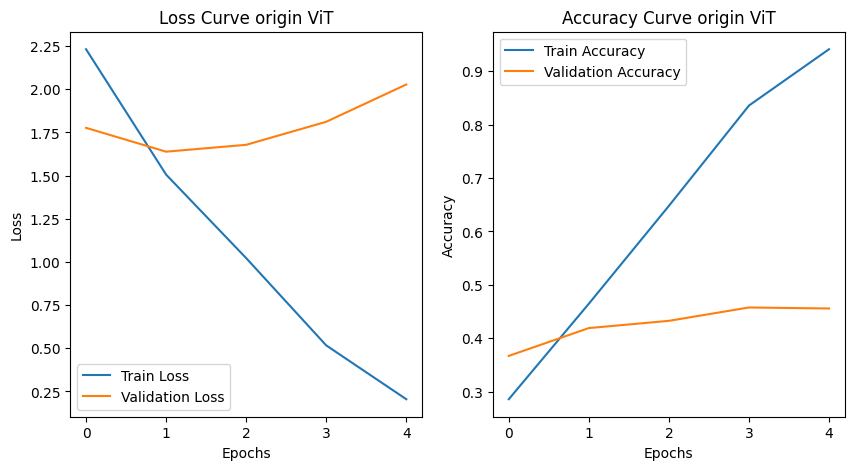

Fold 1/20
38/38 [==============================] - 3s 65ms/step
Run small_noise, in origin at Fold 1/20: Accuracy: 0.4483333333333333, Precision: 0.44926866062298976, Recall: 0.45002361888428577
38/38 [==============================] - 2s 65ms/step
Run small_noise, in medium_noise at Fold 1/20: Accuracy: 0.4091666666666667, Precision: 0.4085217560651066, Recall: 0.41085350642596125
38/38 [==============================] - 2s 65ms/step
Run small_noise, in large_noise at Fold 1/20: Accuracy: 0.3491666666666667, Precision: 0.40445820932089677, Recall: 0.3508931123548571
Fold 2/20
38/38 [==============================] - 4s 87ms/step
Run small_noise, in origin at Fold 2/20: Accuracy: 0.44916666666666666, Precision: 0.44602856612066344, Recall: 0.4491742172539335
38/38 [==============================] - 3s 86ms/step
Run small_noise, in medium_noise at Fold 2/20: Accuracy: 0.425, Precision: 0.42193992202650243, Recall: 0.42493859085846947
38/38 [==============================] - 3s 86ms/step

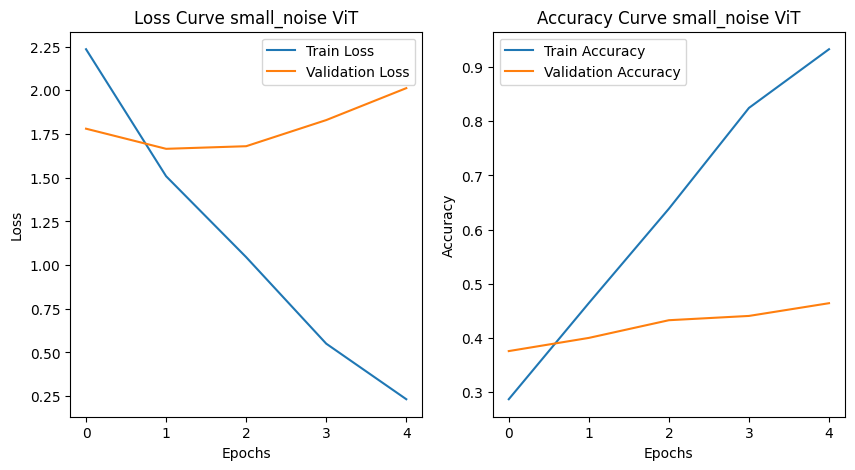

Fold 1/20
38/38 [==============================] - 4s 85ms/step
Run medium_noise, in origin at Fold 1/20: Accuracy: 0.4658333333333333, Precision: 0.4722375042621487, Recall: 0.4650483326278481
38/38 [==============================] - 4s 93ms/step
Run medium_noise, in small_noise at Fold 1/20: Accuracy: 0.4508333333333333, Precision: 0.4628574134204567, Recall: 0.4497891997632433
38/38 [==============================] - 3s 92ms/step
Run medium_noise, in large_noise at Fold 1/20: Accuracy: 0.30666666666666664, Precision: 0.3993918157791023, Recall: 0.30833450247418465
Fold 2/20
38/38 [==============================] - 5s 108ms/step
Run medium_noise, in origin at Fold 2/20: Accuracy: 0.43166666666666664, Precision: 0.43529272378621026, Recall: 0.43219528290359827
38/38 [==============================] - 4s 108ms/step
Run medium_noise, in small_noise at Fold 2/20: Accuracy: 0.42833333333333334, Precision: 0.44036775571183684, Recall: 0.4287360259720464
38/38 [=============================

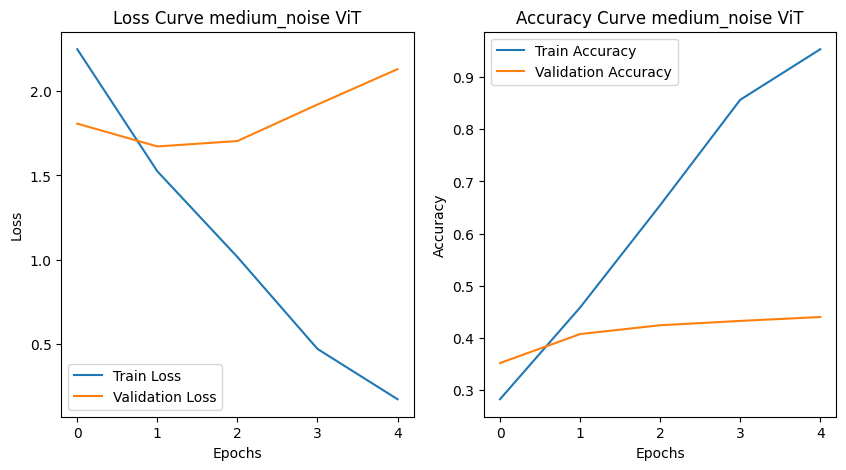

Fold 1/20
38/38 [==============================] - 4s 91ms/step
Run large_noise, in origin at Fold 1/20: Accuracy: 0.35333333333333333, Precision: 0.37187618814281126, Recall: 0.35684435035203854
38/38 [==============================] - 3s 90ms/step
Run large_noise, in small_noise at Fold 1/20: Accuracy: 0.3625, Precision: 0.37580487220939324, Recall: 0.36564359583605327
38/38 [==============================] - 3s 90ms/step
Run large_noise, in medium_noise at Fold 1/20: Accuracy: 0.3358333333333333, Precision: 0.35322944870291123, Recall: 0.33931787122049584
Fold 2/20
38/38 [==============================] - 5s 107ms/step
Run large_noise, in origin at Fold 2/20: Accuracy: 0.3308333333333333, Precision: 0.37087063333138837, Recall: 0.33381327290010077
38/38 [==============================] - 4s 108ms/step
Run large_noise, in small_noise at Fold 2/20: Accuracy: 0.3475, Precision: 0.380739017370832, Recall: 0.34926507063035794
38/38 [==============================] - 4s 109ms/step
Run lar

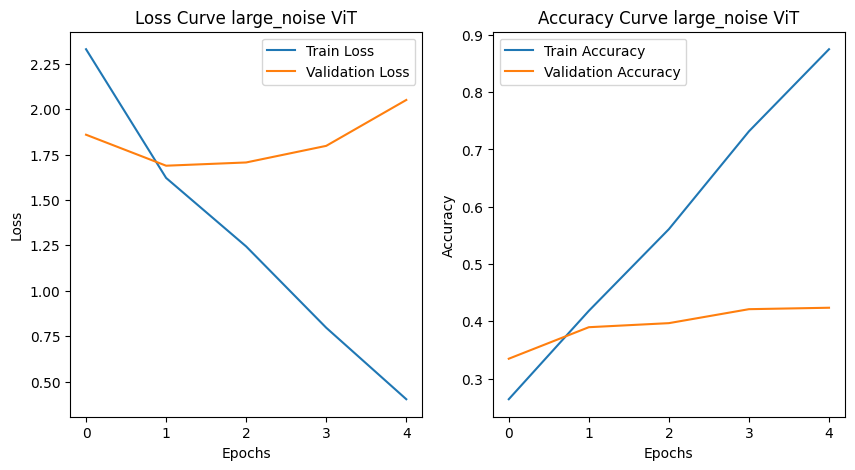

In [20]:
all_performance_ViT = {}
all_histories = {}

for config in best_config_ViT:

    model_name = config['name']

    model_performance = {}

    # data
    # Use 80% for cross validation and 20% for robustness test for other model
    x_processed, y_processed = get_processed_dataset(model_name)
    x_cv, _, y_cv, _ = train_test_split(x_processed, y_processed, test_size=0.2, random_state=66, shuffle=True)
    
    data_augmentation = keras.Sequential(
        [
            layers.Normalization(),
            layers.Resizing(image_size, image_size)
        ],
        name = "data_augmentation"
    )
    data_augmentation.layers[0].adapt(x_processed)
    


    # Cross Validation
    kf = KFold(n_splits=20, shuffle=True, random_state=66)
    all_history = []

    for fold, (train_index, val_index) in enumerate(kf.split(x_cv)):
        print(f'Fold {fold + 1}/{20}')
        
        model = build_ViT_model(config['patch_size'], data_augmentation)
        
        x_train, x_val = x_cv[train_index], x_cv[val_index]
        y_train, y_val = y_cv[train_index], y_cv[val_index]
        
        history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val), verbose=0)
        all_history.append(history.history)
        model_performance_fold = {}


        # Robustness Test
        for dataset_name in all_dataset:
            if dataset_name == model_name:
                # Do robustness evaluations on other dataset
                continue
            # Get rest part of dataset which never used on Cross Validation
            x_evaluated, y_evaluated = get_processed_dataset(dataset_name)
            _, x_test, _, y_test = train_test_split(x_evaluated, y_evaluated, test_size=0.2, random_state=66, shuffle=True)

            y_pred = model.predict(x_test)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true_classes = y_test
            # y_true_classes = np.argmax(y_test, axis=1) 

            accuracy = accuracy_score(y_true_classes, y_pred_classes)
            precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
            recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)

            print(f"Run {model_name}, in {dataset_name} at Fold {fold + 1}/{20}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
            # print(f"y_pred: {y_pred}, y_pred_classes: {y_pred_classes}, y_test: {y_test}, y_true_classes: {y_true_classes}")
        
        
            model_performance_fold[dataset_name] = {'accuracy' : accuracy, 'precision' : precision, 'recall' : recall}

            
        model_performance[fold+1] = model_performance_fold

    all_performance_ViT[model_name] = model_performance

    plot_learning_curves(all_history, model_name)
    all_histories[model_name] = all_history




In [21]:
all_performance_ViT[SMALL][1][ORIGIN]

{'accuracy': 0.4483333333333333,
 'precision': 0.44926866062298976,
 'recall': 0.45002361888428577}

In [22]:
def show_plt(dict, name):
    noise_levels = list(dict.keys())
    accuracy = [dict[noise]['accuracy'] for noise in noise_levels]
    precision = [dict[noise]['precision'] for noise in noise_levels]
    recall = [dict[noise]['recall'] for noise in noise_levels]

    plt.figure(figsize=(7, 6))
    plt.plot(noise_levels, accuracy, marker='o', label='Accuracy')
    plt.plot(noise_levels, precision, marker='o', label='Precision')
    plt.plot(noise_levels, recall, marker='o', label='Recall')

    plt.title(f'Model Performance under Different Noise Levels for {name} model')
    plt.xlabel('Noise Level')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.show()

In [23]:
all_metrics = {}
for model_name in all_dataset:
    dataset_record = {}
    for dataset_name in all_dataset:
        if dataset_name == model_name:
            continue
        dataset_record[dataset_name] = {'accuracy':[], 'precision':[], 'recall':[]}
    all_metrics[model_name] = dataset_record
    for i in range(1, 21):
        for dataset in all_dataset:
            if model_name != dataset:
                dataset_record[dataset]['accuracy'].append(all_performance_ViT[model_name][i][dataset]['accuracy'])
                dataset_record[dataset]['precision'].append(all_performance_ViT[model_name][i][dataset]['precision'])
                dataset_record[dataset]['recall'].append(all_performance_ViT[model_name][i][dataset]['recall'])

In [24]:
for model_name in all_dataset:
    for dataset_name in all_dataset:
        if dataset_name == model_name:
            continue
        all_metrics[model_name][dataset_name]['accuracy'] = np.mean(all_metrics[model_name][dataset_name]['accuracy'])
        all_metrics[model_name][dataset_name]['precision'] = np.mean(all_metrics[model_name][dataset_name]['precision'])
        all_metrics[model_name][dataset_name]['recall'] = np.mean(all_metrics[model_name][dataset_name]['recall'])

all_metrics[ORIGIN]

{'small_noise': {'accuracy': 0.45370833333333344,
  'precision': 0.46767015021634883,
  'recall': 0.4539653569637818},
 'medium_noise': {'accuracy': 0.4381666666666667,
  'precision': 0.4490425364887625,
  'recall': 0.4381621017508944},
 'large_noise': {'accuracy': 0.3272083333333333,
  'precision': 0.3981961514334794,
  'recall': 0.3286956805285518}}

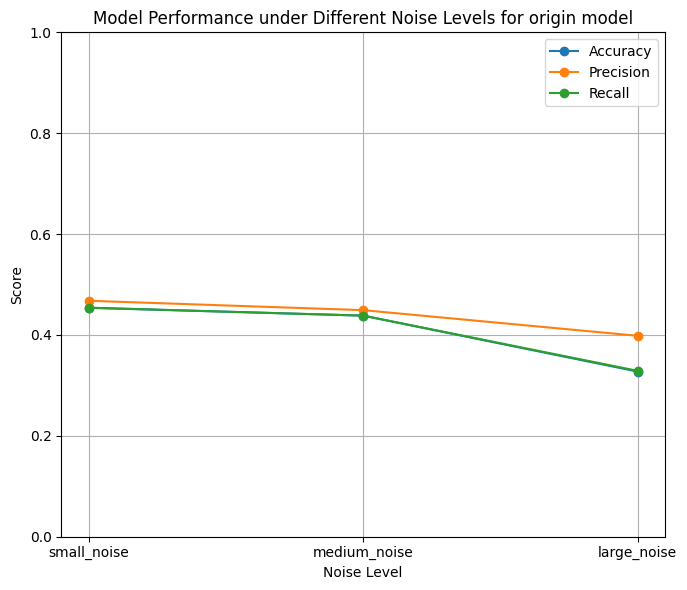

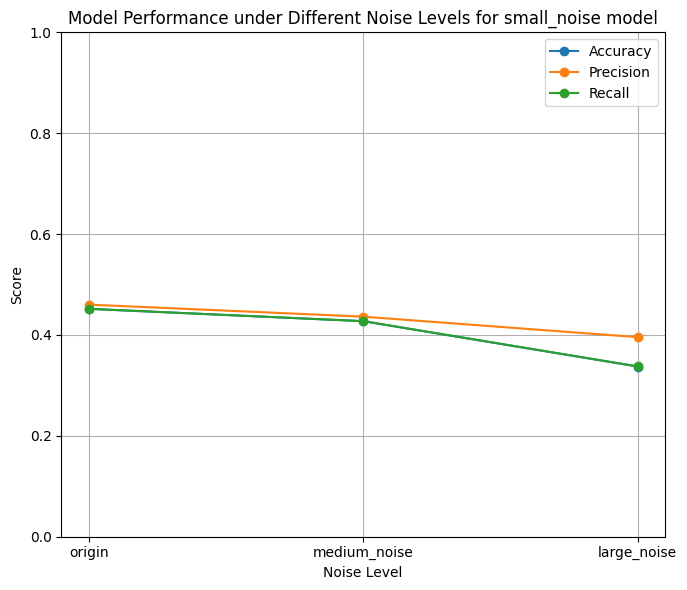

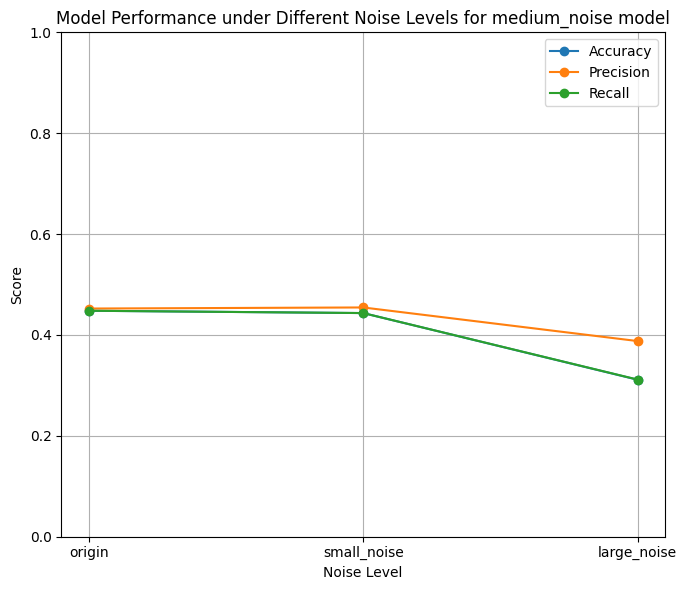

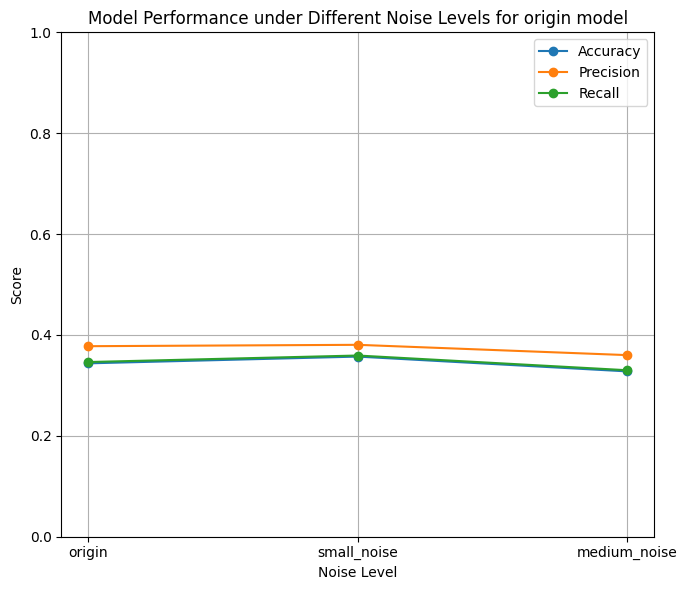

In [25]:
show_plt(all_metrics[ORIGIN], ORIGIN)
show_plt(all_metrics[SMALL], SMALL)
show_plt(all_metrics[MEDIUM], MEDIUM)
show_plt(all_metrics[LARGE], ORIGIN)